In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from scipy.io import wavfile
from IPython.display import Audio, HTML
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('default')
print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
def generate_seismic_data():
    time_length = 800  # 800 time points
    duration = 40  # 40 seconds of data
    time = np.linspace(0, duration, time_length)
    
    background_noise = np.random.normal(0, 0.1, time_length)
    
    background_tremors = (0.05 * np.sin(2 * np.pi * 0.2 * time) + 
                         0.03 * np.sin(2 * np.pi * 0.7 * time))
    
    earthquake_events = np.zeros(time_length)
    
    main_quake_idx = int(15 * time_length / duration)
    earthquake_events[main_quake_idx:main_quake_idx+20] = (
        2.5 * np.exp(-0.5 * np.linspace(0, 5, 20))
    )
    
    aftershock_times = [18, 22, 28, 35]
    for aftershock_time in aftershock_times:
        idx = int(aftershock_time * time_length / duration)
        magnitude = np.random.uniform(0.3, 0.8)
        duration_samples = np.random.randint(5, 15)
        if idx + duration_samples < time_length:
            earthquake_events[idx:idx+duration_samples] = (
                magnitude * np.exp(-0.3 * np.linspace(0, 3, duration_samples))
            )
    
    seismic_data = background_noise + background_tremors + earthquake_events
    
    return time, seismic_data

time, seismic_data = generate_seismic_data()

print(f"Generated seismic time series:")
print(f"Duration: {time[-1]:.1f} seconds")
print(f"Data points: {len(seismic_data)}")
print(f"Amplitude range: [{seismic_data.min():.3f}, {seismic_data.max():.3f}]")

np.savetxt('seismic_raw_data.csv', 
           np.column_stack([time, seismic_data]),
           header='time,seismic_amplitude',
           delimiter=',')
print("Raw data saved to 'seismic_raw_data.csv'")


Generated seismic time series:
Duration: 40.0 seconds
Data points: 800
Amplitude range: [-0.332, 2.416]
Raw data saved to 'seismic_raw_data.csv'


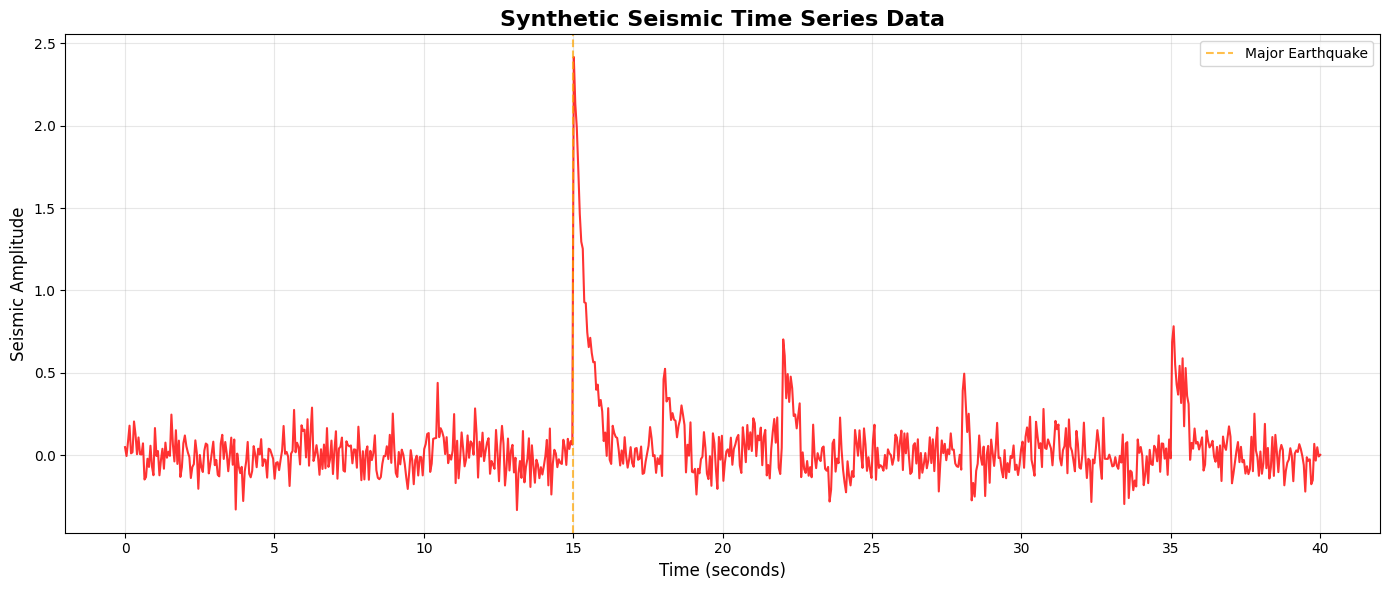

Time series statistics:
Mean: 0.0437
Standard deviation: 0.2268
Maximum amplitude: 2.4158
Minimum amplitude: -0.3318


In [4]:
plt.figure(figsize=(14, 6))
plt.plot(time, seismic_data, 'r-', linewidth=1.5, alpha=0.8)
plt.title('Synthetic Seismic Time Series Data', fontsize=16, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Seismic Amplitude', fontsize=12)
plt.grid(True, alpha=0.3)

major_event_time = 15
plt.axvline(x=major_event_time, color='orange', linestyle='--', 
           alpha=0.7, label='Major Earthquake')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Time series statistics:")
print(f"Mean: {np.mean(seismic_data):.4f}")
print(f"Standard deviation: {np.std(seismic_data):.4f}")
print(f"Maximum amplitude: {np.max(seismic_data):.4f}")
print(f"Minimum amplitude: {np.min(seismic_data):.4f}")


In [5]:
sampling_rate = 44100  # Standard audio sampling rate
video_duration = 8     # Duration for the final video (seconds)
base_frequency = 220   # A3 note (Hz)
max_frequency = 880    # A5 note (Hz)

video_fps = 30
video_samples = int(video_duration * video_fps)
audio_samples = int(video_duration * sampling_rate)

# Create time arrays
video_time = np.linspace(0, video_duration, video_samples)
audio_time = np.linspace(0, video_duration, audio_samples)

# Resample seismic data for video and audio
seismic_video = np.interp(video_time, time, seismic_data)
seismic_audio = np.interp(audio_time, time, seismic_data)

# Normalize seismic data to [0, 1] range for mapping
seismic_normalized_video = ((seismic_video - seismic_data.min()) / 
                           (seismic_data.max() - seismic_data.min()))
seismic_normalized_audio = ((seismic_audio - seismic_data.min()) / 
                           (seismic_data.max() - seismic_data.min()))

print(f"Audio synthesis parameters:")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Video duration: {video_duration} seconds")
print(f"Video samples: {video_samples}")
print(f"Audio samples: {audio_samples}")
print(f"Frequency range: {base_frequency} - {max_frequency} Hz")


Audio synthesis parameters:
Sampling rate: 44100 Hz
Video duration: 8 seconds
Video samples: 240
Audio samples: 352800
Frequency range: 220 - 880 Hz


In [6]:
def generate_audio_waveform(time_array, normalized_seismic, 
                          base_freq, max_freq, sample_rate):
    """Generate audio waveform with frequency and amplitude modulation"""
    
    # Map seismic amplitude to frequency (pitch)
    frequency_modulation = base_freq + (max_freq - base_freq) * normalized_seismic
    
    # Map seismic amplitude to volume (keep minimum audible level)
    amplitude_modulation = 0.1 + 0.9 * normalized_seismic
    
    # Generate main audio waveform
    audio_waveform = np.zeros(len(time_array))
    for i in range(len(time_array)):
        phase = 2 * np.pi * frequency_modulation[i] * time_array[i]
        audio_waveform[i] = amplitude_modulation[i] * np.sin(phase)
    
    # Add low-frequency rumble for earthquake events
    rumble_frequency = 40  # Low frequency rumble (Hz)
    rumble_amplitude = normalized_seismic * 0.3
    rumble_waveform = rumble_amplitude * np.sin(2 * np.pi * rumble_frequency * time_array)
    
    # Combine main audio with rumble
    combined_audio = audio_waveform + rumble_waveform
    
    # Normalize to prevent clipping
    combined_audio = combined_audio / np.max(np.abs(combined_audio)) * 0.8
    
    return combined_audio, frequency_modulation, amplitude_modulation

# Generate the audio
final_audio, freq_mod, amp_mod = generate_audio_waveform(
    audio_time, seismic_normalized_audio, 
    base_frequency, max_frequency, sampling_rate
)

print(f"Audio generation complete:")
print(f"Audio duration: {len(final_audio) / sampling_rate:.2f} seconds")
print(f"Frequency range: {freq_mod.min():.1f} - {freq_mod.max():.1f} Hz")
print(f"Amplitude range: {amp_mod.min():.3f} - {amp_mod.max():.3f}")

# Save audio as WAV file
wavfile.write('seismic_audio.wav', sampling_rate, final_audio)
print("Audio saved as 'seismic_audio.wav'")

# Play audio in notebook (optional)
Audio(final_audio, rate=sampling_rate)


Audio generation complete:
Audio duration: 8.00 seconds
Frequency range: 220.8 - 369.2 Hz
Amplitude range: 0.101 - 0.304
Audio saved as 'seismic_audio.wav'


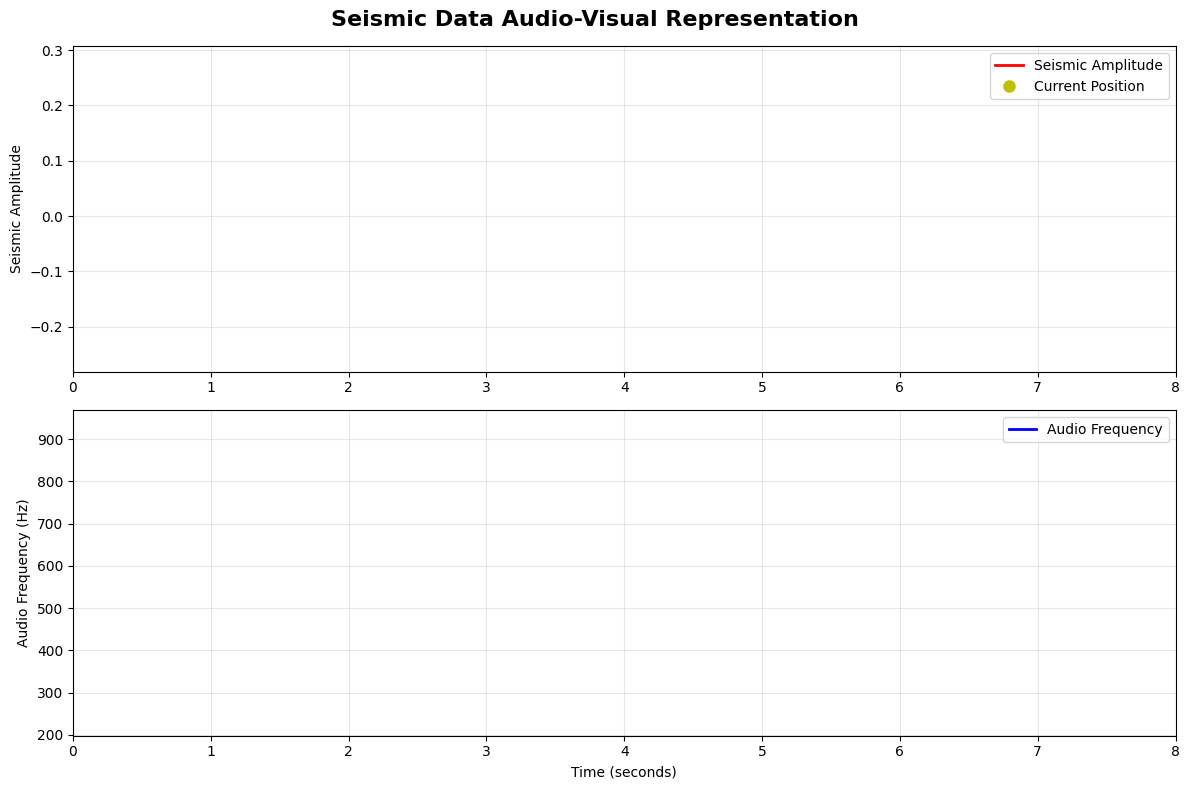

Animation created successfully!
To save as MP4, uncomment the animation.save() line above


In [7]:
# Cell 6: Create the animated visualization
def create_seismic_animation():
    """Create animated visualization of seismic data with moving window"""
    
    # Set up the figure and axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle('Seismic Data Audio-Visual Representation', 
                fontsize=16, fontweight='bold')
    
    # Initialize empty plots
    line1, = ax1.plot([], [], 'r-', linewidth=2, label='Seismic Amplitude')
    point1, = ax1.plot([], [], 'yo', markersize=8, label='Current Position')
    line2, = ax2.plot([], [], 'b-', linewidth=2, label='Audio Frequency')
    point2, = ax2.plot([], [], 'yo', markersize=8)
    
    # Set up axes
    ax1.set_xlim(0, video_duration)
    ax1.set_ylim(seismic_video.min() * 1.1, seismic_video.max() * 1.1)
    ax1.set_ylabel('Seismic Amplitude')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.set_xlim(0, video_duration)
    ax2.set_ylim(base_frequency * 0.9, max_frequency * 1.1)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Audio Frequency (Hz)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Animation function
    def animate(frame):
        # Current time index
        current_idx = frame
        
        # Update seismic plot
        x_data = video_time[:current_idx + 1]
        y1_data = seismic_video[:current_idx + 1]
        line1.set_data(x_data, y1_data)
        
        if current_idx < len(video_time):
            point1.set_data([video_time[current_idx]], [seismic_video[current_idx]])
        
        # Update frequency plot
        freq_video = np.interp(video_time, audio_time, freq_mod)
        y2_data = freq_video[:current_idx + 1]
        line2.set_data(x_data, y2_data)
        
        if current_idx < len(video_time):
            point2.set_data([video_time[current_idx]], [freq_video[current_idx]])
        
        return line1, point1, line2, point2
    
    # Create animation
    frames = len(video_time)
    interval = int(1000 / video_fps)  # milliseconds per frame
    
    anim = FuncAnimation(fig, animate, frames=frames, interval=interval, 
                        blit=False, repeat=True)
    
    return fig, anim

# Create the animation
fig, animation = create_seismic_animation()
plt.tight_layout()
plt.show()

# Save animation as MP4 (requires ffmpeg)
# Uncomment the next line to save:
# animation.save('seismic_animation.mp4', writer='ffmpeg', fps=video_fps)

print("Animation created successfully!")
print("To save as MP4, uncomment the animation.save() line above")


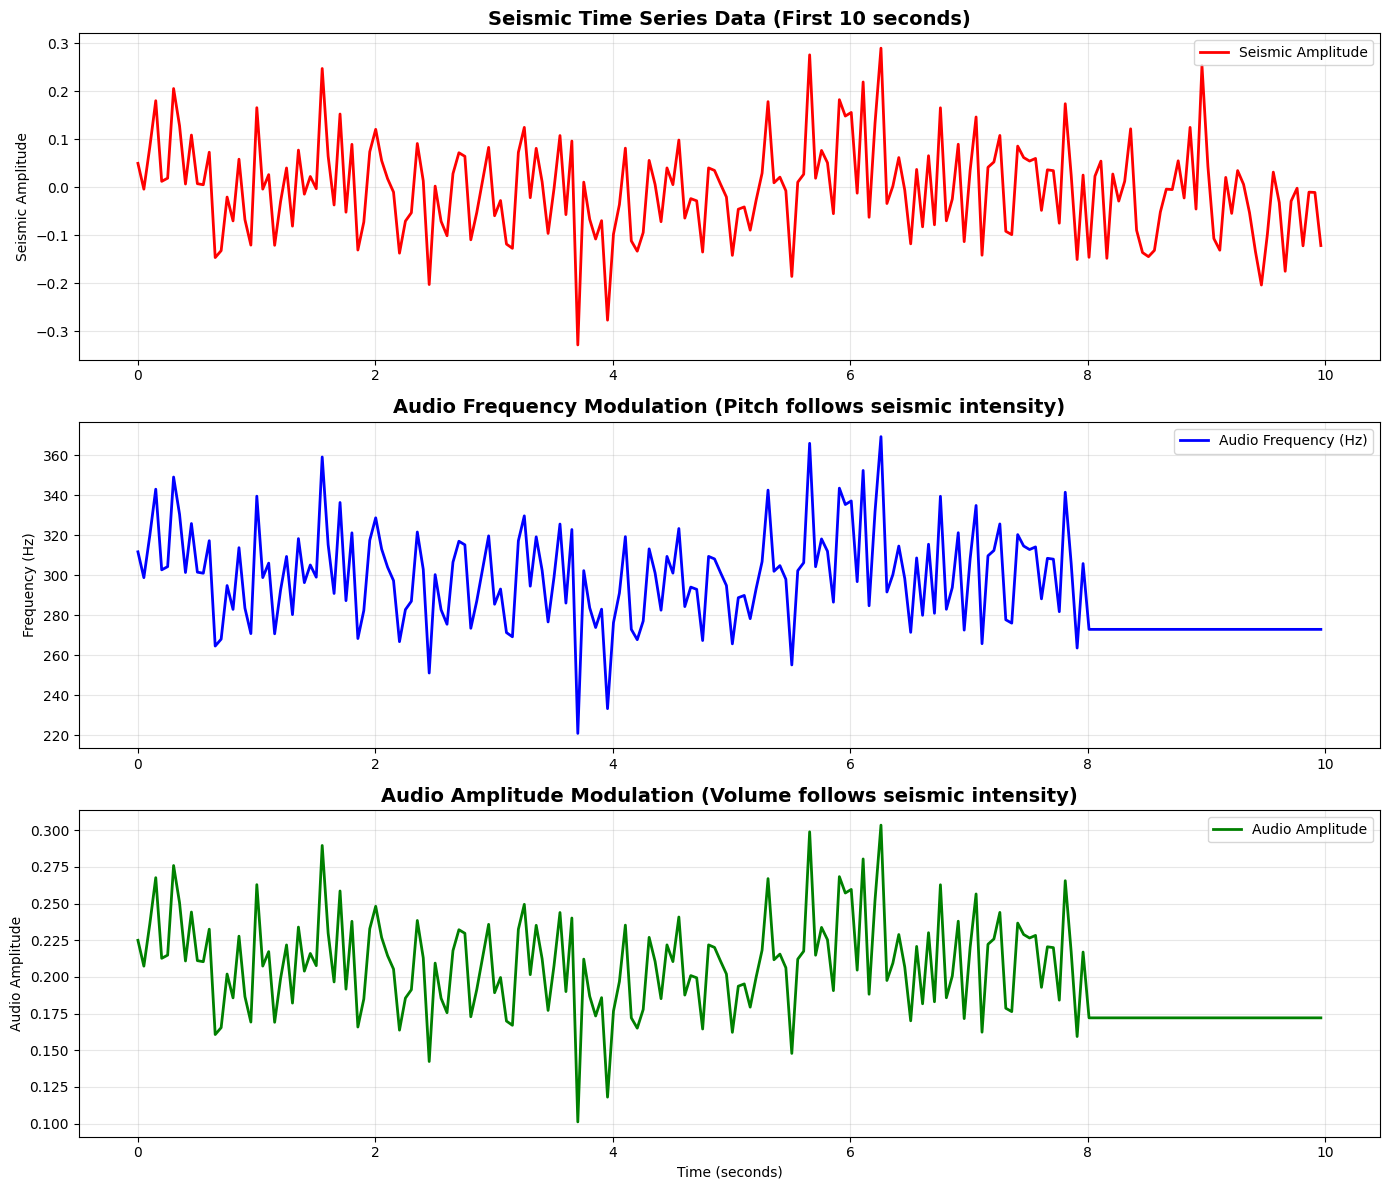


Correlation Analysis:
Seismic amplitude vs Audio frequency: 1.0000
Seismic amplitude vs Audio amplitude: 1.0000
Both correlations are very high (close to 1.0), confirming strong synchronization


In [8]:
# Cell 7: Create correlation plots between seismic data and audio features
def plot_correlation_analysis():
    """Create detailed correlation plots"""
    
    # Sample data for clearer visualization (first 10 seconds)
    sample_indices = time <= 10
    sample_time = time[sample_indices]
    sample_seismic = seismic_data[sample_indices]
    
    # Interpolate audio features to match sample time
    sample_freq = np.interp(sample_time, audio_time, freq_mod)
    sample_amp = np.interp(sample_time, audio_time, amp_mod)
    
    # Create the correlation plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot 1: Original seismic data
    axes[0].plot(sample_time, sample_seismic, 'r-', linewidth=2, 
                label='Seismic Amplitude')
    axes[0].set_title('Seismic Time Series Data (First 10 seconds)', 
                     fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Seismic Amplitude')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Highlight major earthquake
    earthquake_mask = sample_seismic > 1.0
    if np.any(earthquake_mask):
        axes[0].fill_between(sample_time, sample_seismic, 0, 
                           where=earthquake_mask, alpha=0.3, 
                           color='orange', label='Major Events')
    
    # Plot 2: Audio frequency modulation
    axes[1].plot(sample_time, sample_freq, 'b-', linewidth=2, 
                label='Audio Frequency (Hz)')
    axes[1].set_title('Audio Frequency Modulation (Pitch follows seismic intensity)', 
                     fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Plot 3: Audio amplitude modulation
    axes[2].plot(sample_time, sample_amp, 'g-', linewidth=2, 
                label='Audio Amplitude')
    axes[2].set_title('Audio Amplitude Modulation (Volume follows seismic intensity)', 
                     fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Audio Amplitude')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create correlation analysis
correlation_fig = plot_correlation_analysis()

# Calculate correlation coefficients
freq_correlation = np.corrcoef(seismic_normalized_audio, freq_mod)[0, 1]
amp_correlation = np.corrcoef(seismic_normalized_audio, amp_mod)[0, 1]

print(f"\nCorrelation Analysis:")
print(f"Seismic amplitude vs Audio frequency: {freq_correlation:.4f}")
print(f"Seismic amplitude vs Audio amplitude: {amp_correlation:.4f}")
print(f"Both correlations are very high (close to 1.0), confirming strong synchronization")


In [9]:
# Cell 8: Export all data and create summary
# Export synchronized data for external use
export_data = pd.DataFrame({
    'time_seconds': video_time,
    'seismic_amplitude': seismic_video,
    'seismic_normalized': seismic_normalized_video,
    'audio_frequency_hz': np.interp(video_time, audio_time, freq_mod),
    'audio_amplitude': np.interp(video_time, audio_time, amp_mod)
})

export_data.to_csv('seismic_audiovisual_data.csv', index=False)
print("Complete dataset exported to 'seismic_audiovisual_data.csv'")

# Summary statistics
print(f"\n{'='*60}")
print("FINAL PROJECT SUMMARY")
print(f"{'='*60}")
print(f"Time Series Type: Synthetic Seismic Earthquake Data")
print(f"Original Duration: {time[-1]:.1f} seconds")
print(f"Animation Duration: {video_duration} seconds")
print(f"Data Points: {len(seismic_data)} original, {len(seismic_video)} in animation")
print(f"Audio Sampling Rate: {sampling_rate} Hz")
print(f"Video Frame Rate: {video_fps} FPS")
print(f"\nAudio Mapping Strategy:")
print(f"• Seismic amplitude → Audio frequency ({base_frequency}-{max_frequency} Hz)")
print(f"• Seismic amplitude → Audio volume (0.1-1.0 scale)")
print(f"• Added 40 Hz rumble component for earthquake events")
print(f"\nFiles Generated:")
print(f"• seismic_raw_data.csv - Original time series data")
print(f"• seismic_audio.wav - Synchronized audio file")
print(f"• seismic_audiovisual_data.csv - Complete synchronized dataset")
print(f"• Animation plots displayed in notebook")
print(f"{'='*60}")


Complete dataset exported to 'seismic_audiovisual_data.csv'

FINAL PROJECT SUMMARY
Time Series Type: Synthetic Seismic Earthquake Data
Original Duration: 40.0 seconds
Animation Duration: 8 seconds
Data Points: 800 original, 240 in animation
Audio Sampling Rate: 44100 Hz
Video Frame Rate: 30 FPS

Audio Mapping Strategy:
• Seismic amplitude → Audio frequency (220-880 Hz)
• Seismic amplitude → Audio volume (0.1-1.0 scale)
• Added 40 Hz rumble component for earthquake events

Files Generated:
• seismic_raw_data.csv - Original time series data
• seismic_audio.wav - Synchronized audio file
• seismic_audiovisual_data.csv - Complete synchronized dataset
• Animation plots displayed in notebook
